In [323]:
import unicodecsv

with open('data/enrollments.csv', 'rb') as f:
    reader = unicodecsv.DictReader(f)
    enrollments = list(reader)
    
with open('data/daily_engagement.csv','rb') as f:
    reader = unicodecsv.DictReader(f)
    daily_engagement = list(reader)
    

    
with open('data/project_submissions.csv','rb') as f:
    reader = unicodecsv.DictReader(f)
    project_submissions = list(reader) 
    
enrollments[0]

daily_engagement[0]

project_submissions[0]

{'creation_date': '2015-01-14',
 'completion_date': '2015-01-16',
 'assigned_rating': 'UNGRADED',
 'account_key': '256',
 'lesson_key': '3176718735',
 'processing_state': 'EVALUATED'}

In [324]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{'account_key': '448',
 'status': 'canceled',
 'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 'days_to_cancel': 65,
 'is_udacity': True,
 'is_canceled': True}

In [325]:
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{'acct': '0',
 'utc_date': datetime.datetime(2015, 1, 9, 0, 0),
 'num_courses_visited': 1,
 'total_minutes_visited': 11.6793745,
 'lessons_completed': 0,
 'projects_completed': 0}

In [326]:
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 'assigned_rating': 'UNGRADED',
 'account_key': '256',
 'lesson_key': '3176718735',
 'processing_state': 'EVALUATED'}

In [327]:
unique_enrollment = set()

for enrollment in enrollments:
    if enrollment['is_udacity']:
        unique_enrollment.add(enrollment['account_key'])
len(unique_enrollment)

for engagement in daily_engagement:
    engagement['account_key'] = engagement['acct']
    del(engagement['acct'])
    
daily_engagement[0]    
            

{'utc_date': datetime.datetime(2015, 1, 9, 0, 0),
 'num_courses_visited': 1,
 'total_minutes_visited': 11.6793745,
 'lessons_completed': 0,
 'projects_completed': 0,
 'account_key': '0'}

In [328]:
def remove_udacity_accounts(data):
    non_udacity_data = list()


    for students in data:
        
        if students['account_key'] not in test_accounts:
            non_udacity_data.append(students)
            
    return non_udacity_data  

In [329]:
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagements = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print(len(non_udacity_enrollments))

1622


In [330]:

paid_students = {}

for enrollment in enrollments:
    if not enrollment['is_canceled'] or enrollment['days_to_cancel'] > 7:
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']

        if account_key not in paid_students or enrollment_date > paid_students[account_key]:
            paid_students[account_key] = enrollment_date

            
len(paid_students)

999

In [331]:
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >=0

In [332]:
def remove_free_trial_cancels(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data         

In [346]:
paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments)
paid_engagements = remove_free_trial_cancels(non_udacity_engagements)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)

print(len(paid_enrollments))
print(len(paid_engagements))
print(len(paid_submissions))

1293
134549
3618


In [334]:
for enagements in paid_engagements:
    if enagements['num_courses_visited'] > 0:
        enagements['has_visited'] = 1
    else:
        enagements['has_visited'] = 0


In [335]:
paid_engagement_in_first_week = []

for students in paid_engagements:
    account_key = students['account_key']
    join_date = paid_students[account_key]
    engagement_date = students['utc_date']
    
    if within_one_week(join_date , engagement_date):
         paid_engagement_in_first_week.append(students)

len(paid_engagement_in_first_week)        

6919

In [354]:
from collections import defaultdict

def group_data(data , key):
    # Create a dictionary of engagement grouped by student.
    # The keys are account keys, and the values are lists of engagement records.
    engagement_by_account = defaultdict(list)
    for engagement_record in data:
        account_key = engagement_record[key]
        engagement_by_account[account_key].append(engagement_record)
        
    return engagement_by_account
        

In [355]:
def sum_of_grouped_items(engagement_by_account , key):
    
    total_minutes_by_account = {}
    for account_key, engagement_for_student in engagement_by_account.items():
        total_minutes = 0
        for engagement_record in engagement_for_student:
            total_minutes += engagement_record[key]
        total_minutes_by_account[account_key] = total_minutes
    return  total_minutes_by_account     

In [356]:
import numpy as np

# Summarize the data about minutes spent in the classroom
total_minutes = list(sum_of_grouped_items(group_data(paid_engagement_in_first_week,'account_key'),'total_minutes_visited').values())
print ('Mean:',np.mean(total_minutes))
print ('Standard deviation:', np.std(total_minutes))
print ('Minimum:', np.min(total_minutes))
print ('Maximum:', np.max(total_minutes))

Mean: 306.70832675342825
Standard deviation: 412.99693340852957
Minimum: 0.0
Maximum: 3564.7332644989997


In [357]:
total_lessons = list(sum_of_grouped_items(group_data(paid_engagement_in_first_week,'account_key') , 'lessons_completed').values())
print(np.mean(total_lessons))
print(np.std(total_lessons))
print(np.min(total_lessons))
print(np.max(total_lessons))

1.636180904522613
3.002561299829423
0
36


In [340]:
total_courses = list(sum_of_grouped_items(group_data(paid_engagement_in_first_week,'account_key'),'has_visited').values())
print ('Mean:',np.mean(total_courses))
print ('Standard deviation:', np.std(total_courses))
print ('Minimum:', np.min(total_courses))
print ('Maximum:', np.max(total_courses))

Mean: 2.8673366834170855
Standard deviation: 2.2551980029196814
Minimum: 0
Maximum: 7


In [348]:

subway_project_lesson_keys = ['746169184','3176718735']
pass_subway_project= set()

for submissions in paid_submissions:
    lesson_key = submissions['lesson_key']
    assigned_rating = submissions['assigned_rating']
    if lesson_key in subway_project_lesson_keys and (assigned_rating == 'PASSED' or assigned_rating == 'DISTINCTION'):
        pass_subway_project.add(submissions['account_key'])
        
len(pass_subway_project)

647

In [359]:
passing_engagements = []
non_passing_engagements = []

for submissions in paid_engagement_in_first_week:
    if submissions['account_key'] in pass_subway_project:
        passing_engagements.append(submissions)
    else:
        non_passing_engagements.append(submissions)
        
print(len(passing_engagements))

print(len(non_passing_engagements))

4527
2392


In [395]:
passing_engagement_by_account = group_data(passing_engagements,'account_key')
non_passing_engagement_by_account = group_data(non_passing_engagements,'account_key')
total_minutes_for_passed = list(sum_of_grouped_items(passing_engagement_by_account,'total_minutes_visited').values())
print ('Mean:',np.mean(total_minutes_for_passed))


total_minutes_for_nonpassed = list(sum_of_grouped_items(group_data(non_passing_engagements,'account_key'),'total_minutes_visited').values())
print ('Mean:',np.mean(total_minutes_for_nonpassed))



Mean: 394.58604648350865
Mean: 143.32647426675584


Text(0.5, 1.0, 'Distribution of classroom visits in the first week for students who pass the subway project')

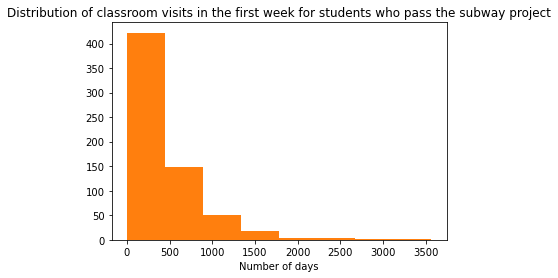

In [404]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(total_minutes_for_nonpassed, bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom visits in the first week ' + 
          'for students who do not pass the subway project')

plt.hist(total_minutes_for_passed, bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom visits in the first week ' + 
          'for students who pass the subway project')